## Pneumonia detection from chest x-ray images##

### Importing the libraries ###

In [66]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.4.1


### Setting the Basic Parameters ###

In [43]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
EPOCHS = 25

### Since the data size is huge (almost 2 GB) we have downloaded the files into local directory and reading from the directory###

### Reading the data from the downloaded files ###

In [44]:
filenames = tf.io.gfile.glob(str("chest_xray/train/*/*"))
filenames.extend(tf.io.gfile.glob(str("chest_xray/val/*/*")))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

### Few utility functions and arrays for data visualization ###

In [45]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

for f in train_list_ds.take(5):
    print(f.numpy())

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

b'chest_xray\\train\\PNEUMONIA\\person22_bacteria_74.jpeg'
b'chest_xray\\train\\NORMAL\\IM-0750-0001.jpeg'
b'chest_xray\\train\\NORMAL\\NORMAL2-IM-1135-0001.jpeg'
b'chest_xray\\train\\PNEUMONIA\\person500_bacteria_2109.jpeg'
b'chest_xray\\train\\PNEUMONIA\\person757_virus_1385.jpeg'
Training images count: 4185
Validating images count: 1047


In [46]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str("C:/Users/amits/Desktop/BITS/DL_Assignment_1/chest_xray/train/*"))])
CLASS_NAMES

array(['NORMAL', 'PNEUMONIA'], dtype='<U9')

In [47]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"

In [48]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

In [49]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [50]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):

    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

test_list_ds = tf.data.Dataset.list_files(str('C:/Users/amits/Desktop/BITS/DL_Assignment_1/chest_xray/train/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

for f in train_list_ds.take(5):
    print(f.numpy())
    
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))
    
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

TEST_IMAGE_COUNT
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

b'chest_xray\\train\\PNEUMONIA\\person22_bacteria_74.jpeg'
b'chest_xray\\train\\NORMAL\\IM-0750-0001.jpeg'
b'chest_xray\\train\\NORMAL\\NORMAL2-IM-1135-0001.jpeg'
b'chest_xray\\train\\PNEUMONIA\\person500_bacteria_2109.jpeg'
b'chest_xray\\train\\PNEUMONIA\\person757_virus_1385.jpeg'
Training images count: 4185
Validating images count: 1047


### Plotted multiple samples from each class (NORMAL, PNEUMONIA) ###

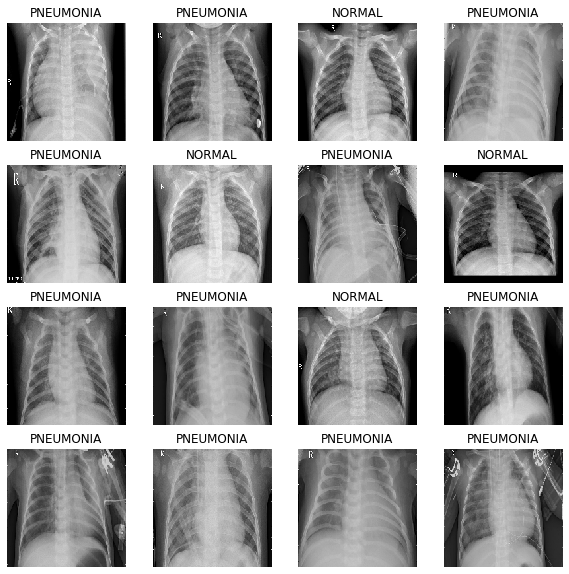

In [85]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")
        
show_batch(image_batch.numpy(), label_batch.numpy())

### Printing Flipped Images ###

In [95]:
def show_batch_flip_lr(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        lr_flipped_image = np.fliplr(image_batch[n])
        plt.imshow(lr_flipped_image)
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")
        
def show_batch_flip_ud(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        ud_flipped_image = np.flipud(image_batch[n])
        plt.imshow(ud_flipped_image)
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")    


Flipped Images - Left to Right and Upside Down :


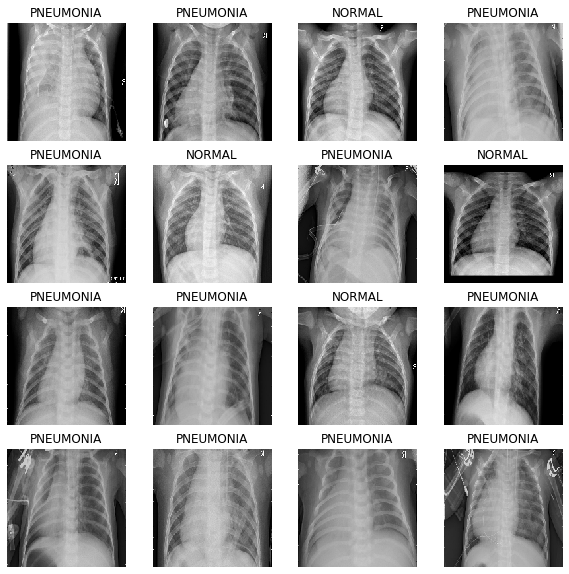

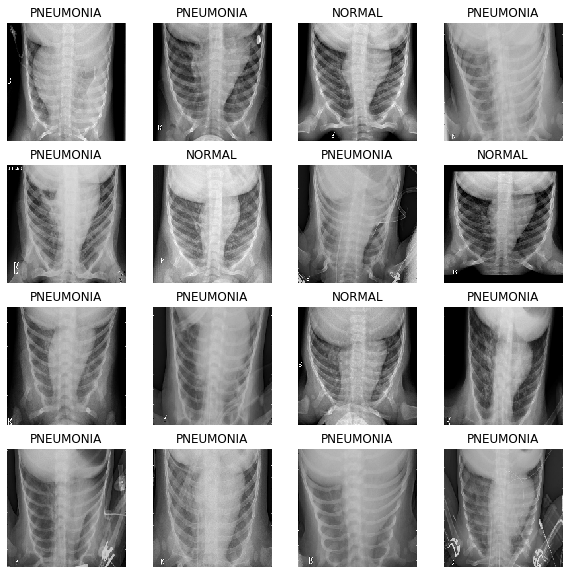

In [96]:
print("Flipped Images - Left to Right and Upside Down :")
show_batch_flip_lr(image_batch.numpy(), label_batch.numpy())

show_batch_flip_ud(image_batch.numpy(), label_batch.numpy())

### Bringing Train and Test data in required format ###

In [52]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

### Printing the shape of Train and Test Data ###

In [53]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

COUNT_NORMAL = len([filename for filename in val_filenames if "NORMAL" in filename])
print("Normal images count in test set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in val_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in test set: " + str(COUNT_PNEUMONIA))

print("\n")

for image, label in train_ds.take(1):
    print("Training Image shape: ", image.numpy().shape)
    print("Training Label: ", label.numpy())
    
print("\n")
    
for image, label in val_ds.take(1):
    print("Test Image shape: ", image.numpy().shape)
    print("Test Label: ", label.numpy())

Normal images count in training set: 1098
Pneumonia images count in training set: 3087
Normal images count in test set: 251
Pneumonia images count in test set: 796


Training Image shape:  (16, 180, 180, 3)
Training Label:  [ True  True  True  True  True  True  True  True False  True  True  True
 False  True False  True]


Test Image shape:  (16, 180, 180, 3)
Test Label:  [ True  True  True  True False  True  True  True False  True  True  True
  True  True  True  True]


### Building the Model with 3 layers with dropout in each layer (to avoid the overfitting and improve the accuracy score), L2 regularization, one explicit droput layer and activation functions###

In [54]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [55]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.MaxPool2D(),
        
        #tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

#Reason for choosing 3 layers : If data is less complex and is having fewer dimensions or features then neural networks 
#with 1 to 2 hidden layers would work. If data is having large dimensions or features then to get an optimum solution, 
#3 to 5 hidden layers can be used. Here data is complex images and hence 3 layers have been used.

#Reason for adding Dropout layer: A Simple Way to Prevent Neural Networks from Overfitting, 2014. Because the outputs of a layer under dropout 
#are randomly subsampled, it has the effect of reducing the capacity or thinning the network during training.

In [56]:
initial_bias = np.log([COUNT_PNEUMONIA/COUNT_NORMAL])
initial_bias

array([1.15414625])

In [57]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 8.34
Weight for class 1: 2.63


### Compiling the Model with Loss Function, Optimizer and Metrics###

In [58]:
with strategy.scope():
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
#Reason for using adam optimizer: Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide 
#an optimization algorithm that can handle sparse gradients on noisy problems. Adam is relatively easy to 
#configure where the default configuration parameters do well on most problems.

### Training the model and printing/plotting the metrics ###

In [72]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
)

Epoch 1/25
261/261 [==============================] - 54s 207ms/step - loss: 24.5998 - accuracy: 0.7981 - precision: 0.9275 - recall: 0.7881 - val_loss: 15.1938 - val_accuracy: 0.8183 - val_precision: 0.8071 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 52s 200ms/step - loss: 19.0233 - accuracy: 0.7986 - precision: 0.9368 - recall: 0.7795 - val_loss: 22.6459 - val_accuracy: 0.8135 - val_precision: 0.8037 - val_recall: 0.9987
Epoch 3/25
261/261 [==============================] - 51s 196ms/step - loss: 16.8546 - accuracy: 0.8204 - precision: 0.9372 - recall: 0.8105 - val_loss: 15.6376 - val_accuracy: 0.8596 - val_precision: 0.8462 - val_recall: 0.9962
Epoch 4/25
261/261 [==============================] - 53s 204ms/step - loss: 17.8545 - accuracy: 0.7981 - precision: 0.9368 - recall: 0.7791 - val_loss: 11.6800 - val_accuracy: 0.4356 - val_precision: 0.9951 - val_recall: 0.2582
Epoch 5/25
261/261 [==============================] - 50s 192ms/step - loss: 19.5128

In [73]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [74]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [75]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=100,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Epoch 1/100
261/261 [==============================] - 52s 199ms/step - loss: 108.4241 - accuracy: 0.7845 - precision: 0.9232 - recall: 0.7722 - val_loss: 64.6079 - val_accuracy: 0.7587 - val_precision: 0.7587 - val_recall: 1.0000
Epoch 2/100
261/261 [==============================] - 54s 205ms/step - loss: 59.2816 - accuracy: 0.7943 - precision: 0.9316 - recall: 0.7782 - val_loss: 53.6841 - val_accuracy: 0.7596 - val_precision: 0.7596 - val_recall: 1.0000
Epoch 3/100
261/261 [==============================] - 48s 186ms/step - loss: 50.0694 - accuracy: 0.8024 - precision: 0.9319 - recall: 0.7901 - val_loss: 58.0050 - val_accuracy: 0.7606 - val_precision: 0.7606 - val_recall: 1.0000
Epoch 4/100
261/261 [==============================] - 48s 183ms/step - loss: 42.1233 - accuracy: 0.8147 - precision: 0.9411 - recall: 0.7986 - val_loss: 43.7708 - val_accuracy: 0.7596 - val_precision: 0.7596 - val_recall: 1.0000
Epoch 5/100
261/261 [==============================] - 49s 187ms/step - loss: 4

### Model Evaluation ###

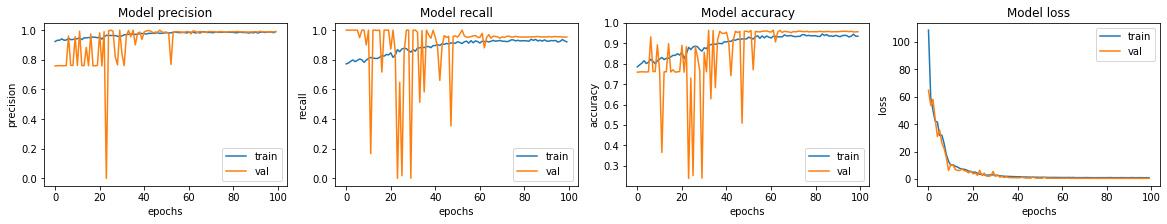

In [76]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [77]:
loss, acc, prec, rec = model.evaluate(test_ds)

326/326 [==============================] - 84s 252ms/step - loss: 0.4311 - accuracy: 0.9655 - precision: 0.9962 - recall: 0.9572


### Hyperparameter 1 - Change in Batch Size ###

Epoch 1/100
130/130 [==============================] - 26s 197ms/step - loss: 132.0339 - accuracy: 0.7370 - precision: 0.9033 - recall: 0.7177 - val_loss: 30.2324 - val_accuracy: 0.3203 - val_precision: 1.0000 - val_recall: 0.0794
Epoch 2/100
130/130 [==============================] - 28s 216ms/step - loss: 27.7882 - accuracy: 0.7635 - precision: 0.9098 - recall: 0.7630 - val_loss: 18.8179 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 3/100
130/130 [==============================] - 28s 217ms/step - loss: 21.2935 - accuracy: 0.7721 - precision: 0.9127 - recall: 0.7660 - val_loss: 22.6102 - val_accuracy: 0.7422 - val_precision: 0.7422 - val_recall: 1.0000
Epoch 4/100
130/130 [==============================] - 36s 275ms/step - loss: 20.2954 - accuracy: 0.7856 - precision: 0.9162 - recall: 0.7858 - val_loss: 16.5581 - val_accuracy: 0.7266 - val_precision: 0.7266 - val_recall: 1.0000
Epoch 5/100
130/130 [==============================] - 34s 262ms/step - loss: 1

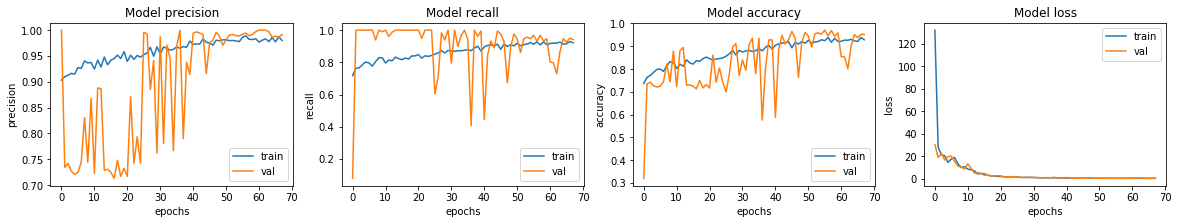

In [41]:
#Impact of higher batch size : higher batch sizes leads to lower asymptotic test accuracy.
#larger batch sizes make larger gradient steps than smaller batch sizes for the same number of samples seen.

BATCH_SIZE = 32 * strategy.num_replicas_in_sync

history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=100,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    
loss, acc, prec, rec = model.evaluate(test_ds)


### Hyperparameter 2 - Changing the position and value of dropout layer ###

Epoch 1/25
130/130 [==============================] - 36s 222ms/step - loss: 10.0221 - accuracy: 0.7751 - precision: 0.9227 - recall: 0.7554 - val_loss: 4.5470 - val_accuracy: 0.6797 - val_precision: 0.9787 - val_recall: 0.59132 - accuracy: 0.7474  - ETA: 4s - loss: 10.4506 - accuracy: 0.7621 - precision: 0.9169 - recall:  - ETA: 3s - loss: 10.3928 - accuracy: 0.7641 - precision: 0.9177 - recall:  - ETA: 3s - loss: 10.3355 - accuracy: 0.7660 - 
Epoch 2/25
130/130 [==============================] - 28s 217ms/step - loss: 3.4249 - accuracy: 0.8696 - precision: 0.9692 - recall: 0.8577 - val_loss: 2.3887 - val_accuracy: 0.8184 - val_precision: 0.8044 - val_recall: 0.9892
Epoch 3/25
130/130 [==============================] - 29s 222ms/step - loss: 2.2154 - accuracy: 0.8909 - precision: 0.9555 - recall: 0.8896 - val_loss: 2.0790 - val_accuracy: 0.8145 - val_precision: 0.9892 - val_recall: 0.7500
Epoch 4/25
130/130 [==============================] - 29s 222ms/step - loss: 1.7829 - accuracy: 0

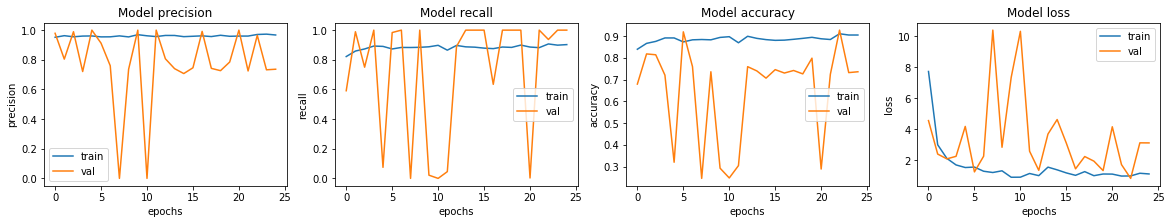

In [42]:
#Impact of change of dropout layer : Because the outputs of a layer under dropout are randomly subsampled, 
#it has the effect of reducing the capacity or thinning the network during training. As such, a wider network, 
#e.g. more nodes, may be required when using dropout. Hence change of layer and dropout parameter will impact the 
#model output metrics

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.MaxPool2D(),
        
        #tf.keras.layers.Dropout(0.2),
        
        #tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.0),
        dense_block(128, 0.4),
        dense_block(64, 0.0),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

with strategy.scope():
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
)

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    
loss, acc, prec, rec = model.evaluate(test_ds)